## Import libraries

In [108]:

import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
import re
import os
import time
import math



### constants to sync with values in d435-capture.ipynb



In [109]:
depth_scale = 9.999999747378752e-05
#imgfolder = "D:/d435/manu-bear-20181027/"
imgfolder = "D:/d435/puzzle-box-20181027/"

width = 1280
height = 720


### fetch all file names


In [111]:
filelist = sorted(os.listdir(imgfolder))

# ['c_1540534762479.1584.npy', 'c_1540534762645.808.npy', 'c_1540534762813.2444.npy', 
#  'd_1540534762479.1584.npy', 'd_1540534762645.808.npy', 'd_1540534762813.2444.npy']
#print(filelist)

timesteps = []
filetimes = []
color_files = []
depth_files = []
base_time = -1.0

for f in filelist:
    result = re.search('c_(.*).npy', f)
    if result and result.group(1):
        t = result.group(1)
        timesteps.append(float(t))
        if base_time < 0:
            base_time = float(t)
        filetimes.append(t)
        color_files.append(f)
        depth_files.append("d_" + t + ".npy")

#print(timesteps)
#print(depth_files)
print(len(depth_files))

855


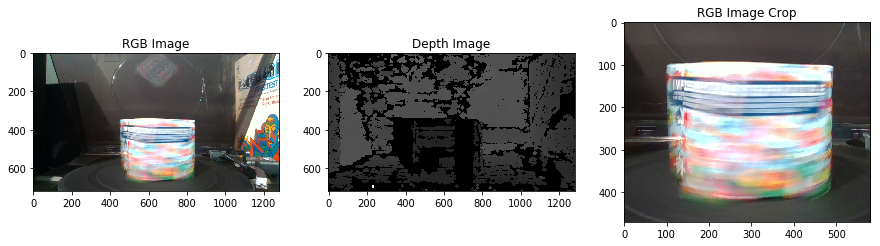

In [118]:
color_image = np.load(imgfolder + color_files[10])
depth_image = np.load(imgfolder + depth_files[10])


# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(depth_image, cmap='gray')

cimage = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
table3 = fig.add_subplot(1,3,3)
table3.set_title("RGB Image Crop")
table3.imshow(cimage[250:,350:930,:])


In [119]:
print(depth_image.shape)
print(depth_image[450,600])
print(depth_image[450,600]*depth_scale)

print(color_image.shape)
print(color_image[450,600])

max_depth = int(0.5/depth_scale)
print("Max Depth Int ",max_depth)

min_depth = int(0.2/depth_scale)
print("Min Depth Int ",min_depth)

(720, 1280)
2595
0.259499993444
(720, 1280, 3)
[226 210 198]
Max Depth Int  5000
Min Depth Int  2000


In [124]:
radian_size = 6283
h_fov = 69.4*math.pi/180
# the tangent constant for the FOV/2 of the camera
fov_tan = math.tan(h_fov/2)
print("fov tan",fov_tan)
print("depth scale",depth_scale)
# distance between turntable center and camera
# Sony turntable distance = 31cm
turn_dist = 0.31

# 33.33 rpm = 3.49065846509342 rad/s
rotate_speed = 3.49065846509342

cylinder_depth = np.zeros((720,radian_size), dtype=float)
cylinder_count = np.zeros((720,radian_size), dtype=int)
cylinder_r = np.zeros((720,radian_size), dtype=float)
cylinder_g = np.zeros((720,radian_size), dtype=float)
cylinder_b = np.zeros((720,radian_size), dtype=float)


#    x′ = x cos ⁡ θ − y sin ⁡ θ
#    y′ = x sin ⁡ θ + y cos ⁡ θ
point_count = 0
max_coord = 0
min_coord = 1000000

#for n in range(len(depth_files)):
for n in range(len(depth_files)):
    print("Processing ",n," file ",color_files[n])
    color_image = np.load(imgfolder + color_files[n])
    depth_image = np.load(imgfolder + depth_files[n])
    # timedelta is in seconds
    time_delta = (timesteps[n] - base_time)/1000
    angle_delta = (time_delta * rotate_speed) % (2*math.pi)
    print(angle_delta)
    #print(depth_image[450,180])
    for x in range(350,width-350):
        for z in range(250,height):
            y = depth_image[z,x]
            if max_coord < y:
                max_coord = y
            if min_coord > y:
                min_coord = y

            r = color_image[z,x,2]
            g = color_image[z,x,1]
            b = color_image[z,x,0]
            # cam_y is in metres
            cam_y = y * depth_scale
            if cam_y < 0.05:
                continue
            if cam_y > (turn_dist*1.4):
                continue
            # x in camera coord
            cam_x = ((x - (width/2))/(width/2)) * cam_y *  fov_tan
            # convert to center of turntable coordinates
            turn_x = cam_x
            turn_y = cam_y - turn_dist
            # rotate by angle_delta
            rot_x = turn_x * math.cos(angle_delta) - turn_y * math.sin(angle_delta)
            rot_y = turn_x * math.sin(angle_delta) + turn_y * math.cos(angle_delta)            
            # rot_radius = depth is now distance from the turntable center
            # rot_angle is between -pi and pi
            rot_radius = math.sqrt(rot_x*rot_x + rot_y*rot_y)
            rot_angle = math.atan2(rot_y, rot_x)
            rot_coord = int(radian_size * (rot_angle + math.pi)/(2*math.pi))
            # record into the arrays
            if cylinder_count[z, rot_coord] > 0:
                count = cylinder_count[z, rot_coord]
                cylinder_depth[z, rot_coord] = ((cylinder_depth[z, rot_coord] * count) + rot_radius) / (count + 1)
                cylinder_r[z, rot_coord] = ((cylinder_r[z, rot_coord] * count) + r) / (count + 1)
                cylinder_g[z, rot_coord] = ((cylinder_g[z, rot_coord] * count) + g) / (count + 1)
                cylinder_b[z, rot_coord] = ((cylinder_b[z, rot_coord] * count) + b) / (count + 1)
            else:
                cylinder_depth[z, rot_coord] = rot_radius
                cylinder_r[z, rot_coord] = r
                cylinder_g[z, rot_coord] = g
                cylinder_b[z, rot_coord] = b
            cylinder_count[z, rot_coord] += 1
            #if max_coord < rot_coord:
            #    max_coord = rot_coord
            #if min_coord > rot_coord:
            #    min_coord = rot_coord
            point_count += 1
    print("Point count", point_count)
    point_count = 0
            
print("Done")
#print("Point count", point_count)
#print("Max Min ", max_coord, " ", min_coord)

fov tan 0.69243282809315
depth scale 9.999999747378752e-05
Processing  0  file  c_1540618399152.5557.npy
0.0
Point count 85423
Processing  1  file  c_1540618399318.6753.npy
0.5798668888597792
Point count 73954
Processing  2  file  c_1540618399485.559.npy
1.1624011998376595
Point count 56111
Processing  3  file  c_1540618399652.594.npy
1.7454630297583849
Point count 80061
Processing  4  file  c_1540618399818.7056.npy
2.3253017956373663
Point count 99460
Processing  5  file  c_1540618399985.725.npy
2.9083099362311136
Point count 80465
Processing  6  file  c_1540618400154.518.npy
3.4975085414465497
Point count 65776
Processing  7  file  c_1540618400319.2368.npy
4.072485440493657
Point count 65776
Processing  8  file  c_1540618400486.1924.npy
4.6552703016641
Point count 80091
Processing  9  file  c_1540618400652.8733.npy
5.237096424852798
Point count 80515
Processing  10  file  c_1540618400819.6802.npy
5.81936228919579
Point count 72233
Processing  11  file  c_1540618400988.57.npy
0.125713

Point count 74431
Processing  99  file  c_1540618416164.6252.npy
2.834656923841699
Point count 75998
Processing  100  file  c_1540618416330.9087.npy
3.4150956466443603
Point count 88172
Processing  101  file  c_1540618416495.8984.npy
3.9910185005001253
Point count 88172
Processing  102  file  c_1540618416664.9504.npy
4.581121302158792
Point count 65890
Processing  103  file  c_1540618416829.6567.npy
5.156054738417396
Point count 65890
Processing  104  file  c_1540618416996.3403.npy
5.73789023593303
Point count 85016
Processing  105  file  c_1540618417163.4707.npy
0.03809997338603921
Point count 85159
Processing  106  file  c_1540618417329.8906.npy
0.6190150824391978
Point count 79775
Processing  107  file  c_1540618417496.2776.npy
1.1998151429345398
Point count 79103
Processing  108  file  c_1540618417663.31.npy
1.782868450739869
Point count 110322
Processing  109  file  c_1540618417831.0276.npy
2.36831306412455
Point count 74714
Processing  110  file  c_1540618417997.604.npy
2.9497744

Point count 77541
Processing  197  file  c_1540618434007.205.npy
2.2851561886485356
Point count 72483
Processing  198  file  c_1540618434175.9207.npy
2.874084642806018
Point count 95862
Processing  199  file  c_1540618434343.1335.npy
3.4577677349388907
Point count 74891
Processing  200  file  c_1540618434510.203.npy
4.040949726686684
Point count 80628
Processing  201  file  c_1540618434674.4575.npy
4.614306571597517
Point count 130592
Processing  202  file  c_1540618434840.7085.npy
5.194631950265453
Point count 90224
Processing  203  file  c_1540618435008.4185.npy
5.780050145092424
Point count 87211
Processing  204  file  c_1540618435174.8008.npy
0.07764870638894195
Point count 68235
Processing  205  file  c_1540618435341.8015.npy
0.6605912266941658
Point count 66351
Processing  206  file  c_1540618435841.4373.npy
2.404648959624211
Point count 73604
Processing  207  file  c_1540618436175.7708.npy
3.5716930079281326
Point count 82047
Processing  208  file  c_1540618436511.139.npy
4.7423

Point count 87414
Processing  295  file  c_1540618452351.7383.npy
3.4878032305282787
Point count 73208
Processing  296  file  c_1540618452518.3188.npy
4.069279094774295
Point count 84801
Processing  297  file  c_1540618452685.502.npy
4.652858217099414
Point count 71028
Processing  298  file  c_1540618452854.6787.npy
5.243396498854658
Point count 90631
Processing  299  file  c_1540618453019.2512.npy
5.8178629231897006
Point count 73184
Processing  300  file  c_1540618453188.168.npy
0.12430829247598751
Point count 63286
Processing  301  file  c_1540618453352.602.npy
0.6982915128682663
Point count 118209
Processing  302  file  c_1540618453521.8909.npy
1.2892209597200548
Point count 77912
Processing  303  file  c_1540618453687.8247.npy
1.8684393155984225
Point count 80781
Processing  304  file  c_1540618453852.8965.npy
2.444648512531373
Point count 75204
Processing  305  file  c_1540618454019.5327.npy
3.026318681008391
Point count 76701
Processing  306  file  c_1540618454188.48.npy
3.61605

Point count 74954
Processing  393  file  c_1540618470198.792.npy
2.953919271793346
Point count 71491
Processing  394  file  c_1540618470363.4731.npy
3.528764930263371
Point count 66564
Processing  395  file  c_1540618470530.392.npy
4.1114219597029305
Point count 71693
Processing  396  file  c_1540618470699.3362.npy
4.70114808386122
Point count 103204
Processing  397  file  c_1540618470864.4731.npy
5.277584821275205
Point count 65729
Processing  398  file  c_1540618471030.2805.npy
5.856361731576179
Point count 72946
Processing  399  file  c_1540618471199.0332.npy
0.1622344147079957
Point count 125736
Processing  400  file  c_1540618471363.574.npy
0.7365900515429473
Point count 82984
Processing  401  file  c_1540618471533.0215.npy
1.3280734358953055
Point count 82155
Processing  402  file  c_1540618471699.9043.npy
1.9106043380270705
Point count 62319
Processing  403  file  c_1540618471865.182.npy
2.4875319492876997
Point count 68397
Processing  404  file  c_1540618472033.2717.npy
3.07427

Point count 77455
Processing  491  file  c_1540618486873.8164.npy
4.612066633763732
Point count 87787
Processing  492  file  c_1540618487040.3196.npy
5.193272346951858
Point count 80051
Processing  493  file  c_1540618487207.1504.npy
5.775621728025669
Point count 91744
Processing  494  file  c_1540618487376.5615.npy
0.08379282567907609
Point count 61562
Processing  495  file  c_1540618487540.566.npy
0.6562761537621
Point count 62859
Processing  496  file  c_1540618487708.469.npy
1.2423684479167392
Point count 124699
Processing  497  file  c_1540618487874.2913.npy
1.8211973431215611
Point count 80937
Processing  498  file  c_1540618488041.3171.npy
2.4042276412153925
Point count 74107
Processing  499  file  c_1540618488207.9375.npy
2.985842415942308
Point count 54779
Processing  500  file  c_1540618488376.8936.npy
3.575610298465996
Point count 73981
Processing  501  file  c_1540618488541.455.npy
4.150038373281781
Point count 114260
Processing  502  file  c_1540618488708.4775.npy
4.733056

Point count 82727
Processing  589  file  c_1540618503551.1743.npy
6.278359433627124
Point count 75398
Processing  590  file  c_1540618503720.1057.npy
0.584855935605745
Point count 81626
Processing  591  file  c_1540618503887.1838.npy
1.1680686069689301
Point count 54447
Processing  592  file  c_1540618504051.675.npy
1.7422512448614071
Point count 70159
Processing  593  file  c_1540618504218.8423.npy
2.325774973436424
Point count 129600
Processing  594  file  c_1540618504386.1804.npy
2.909895250089008
Point count 88084
Processing  595  file  c_1540618504552.0671.npy
3.488949129140238
Point count 71575
Processing  596  file  c_1540618504719.0923.npy
4.071976870599386
Point count 71683
Processing  597  file  c_1540618504886.2266.npy
4.655385550616657
Point count 69615
Processing  598  file  c_1540618505052.4937.npy
5.235767175246181
Point count 99041
Processing  599  file  c_1540618505219.1973.npy
5.817672554108029
Point count 87823
Processing  600  file  c_1540618505385.3225.npy
0.114373

Point count 125393
Processing  687  file  c_1540618520064.1243.npy
1.0875748925533273
Point count 83180
Processing  688  file  c_1540618520231.0293.npy
1.670183345935122
Point count 83505
Processing  689  file  c_1540618520395.304.npy
2.2436100721922045
Point count 64150
Processing  690  file  c_1540618520563.1333.npy
2.8294449984619447
Point count 66759
Processing  691  file  c_1540618520729.3596.npy
3.4096843037643723
Point count 123040
Processing  692  file  c_1540618520896.0632.npy
3.99158968262622
Point count 85871
Processing  693  file  c_1540618521065.912.npy
4.5844741027492475
Point count 72925
Processing  694  file  c_1540618521232.7388.npy
5.166808996226955
Point count 64049
Processing  695  file  c_1540618521397.0447.npy
5.740344805561044
Point count 78860
Processing  696  file  c_1540618521565.9287.npy
0.04667597850104244
Point count 99268
Processing  697  file  c_1540618521730.0393.npy
0.61953001860374
Point count 76336
Processing  698  file  c_1540618521896.141.npy
1.1993

Point count 121782
Processing  785  file  c_1540618536571.568.npy
2.1607557318126567
Point count 80512
Processing  786  file  c_1540618536738.5986.npy
2.7438022219256766
Point count 74109
Processing  787  file  c_1540618536904.775.npy
3.3238668238625166
Point count 56796
Processing  788  file  c_1540618537074.6523.npy
3.916850952735757
Point count 72379
Processing  789  file  c_1540618537238.93.npy
4.490287905531233
Point count 115356
Processing  790  file  c_1540618537405.769.npy
5.072666261797423
Point count 86643
Processing  791  file  c_1540618537574.634.npy
5.662116269416941
Point count 69088
Processing  792  file  c_1540618537739.6802.npy
6.238235984138299
Point count 86697
Processing  793  file  c_1540618537908.1165.npy
0.5430042011152025
Point count 72234
Processing  794  file  c_1540618538074.8516.npy
1.125019515265656
Point count 87467
Processing  795  file  c_1540618538241.6848.npy
1.7073774184548327
Point count 67310
Processing  796  file  c_1540618538575.1543.npy
2.8714054

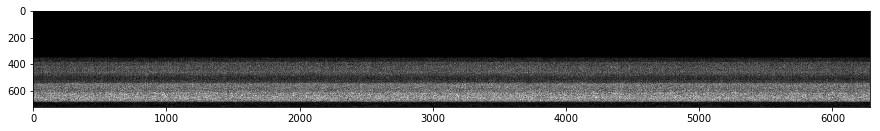

In [125]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_count, cmap='gray')
plt.show()


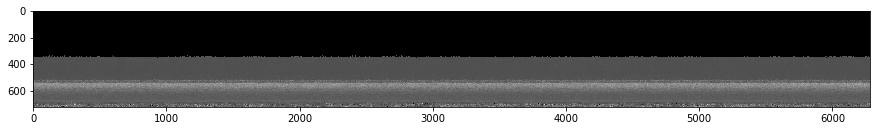

In [126]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_depth, cmap='gray')
plt.show()


In [1]:
rgbArray = np.zeros((720,radian_size,3), 'uint8')
rgbArray[..., 0] = cylinder_r
rgbArray[..., 1] = cylinder_g
rgbArray[..., 2] = cylinder_b

fig = plt.figure(figsize=(14, 14))
plt.imshow(rgbArray)
plt.show()

fig = plt.figure(figsize=(15, 15))
plt.imshow(rgbArray[:,4000:5500,:])
plt.show()


NameError: name 'np' is not defined